# [E08] Semantic Segmentation

### 목차
1. DeepLab Model Preparation
2. Background Blur
    1. 인물모드 사진 (case 1~5)
    2. 고양이 사진 (case 6~8)
    3. 배경 전환 크로마키 사진
3. 문제점 해결
4. 회고

### 루브릭 평가 기준
1. 인물모드 사진을 성공적으로 제작하였다.
    * 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
    * 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
    * 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시

## 1. DeepLab Model Preparation

### 1.1 Image Preparation

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
import os
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/iu_image_1.png'
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

(900, 600, 3)


* urllib: URL을 여는데 도움이 되는 함수와 클래스를 정의한 라이브러리
* 이미지 사이즈는 (900, 600 ,3)

### 1.2 DeepLab Model

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

* DeepLabModel 클래스를 정의
* init: tar file에서 읽어들인 graph_def를 tf.compat.v1.import_graph_def()를 이용하여 활용
* preprocess: 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 Numpy array로 변환

In [4]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


* 사전에 학습된 가중치(pretrained weight)
* Google에서 제공하는 파일을 다운로드 후 사용
* 'deeplabv3_mnv2_pascal_train_aug_2018_01_29' weight를 이용하여 DeepLabModel을 초기화

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(900, 600, 3) (513, 341, 3) 16


* 이미지를 resize

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

* LABEL_NAMES: DeepLab에서 사용할 수 있는 PASCAL VOC의 label
* 해당 노드에서는 'person' (15), 'cat' (8)을 사용할 예정

## 2. Background Blur

### 2.1 인물모드 사진

### Case 1

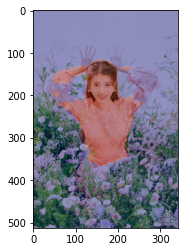

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

* 이미지 내에서, mask를 이용하여 사람의 영역만을 검출해 출력

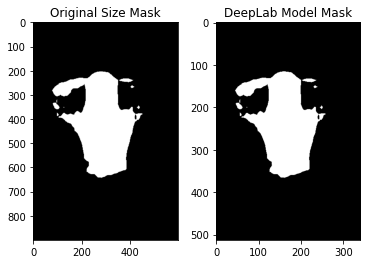

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

* 이전에 DeepLab model을 이용하기 위해서 이미지를 resize하여 입력했기 때문에, 출력된 mask도 resize 이미지와 크기가 같음
* 따라서, mask를 원래 크기로 복원

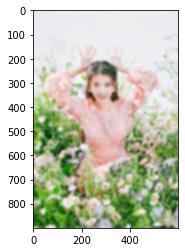

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

* cv2.blur()를 이용하여 이미지를 블러 처리

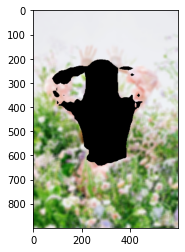

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

* 앞서 블러 처리한 이미지에서, 기존에 만들었던 mask를 이용하여 mask 영역은 검은색으로 만들고, 블러 처리된 배경만 추출

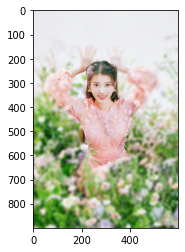

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* mask가 255인 부분만 원본 이미지를 가져오고, 나머지 부분은 블러된 이미지 값을 사용
* 즉, mask 영역을 제외한 나머지 부분은 모두 블러 처리된 이미지를 사용

### Case 2

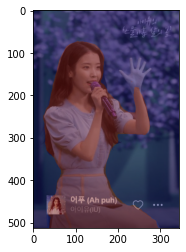

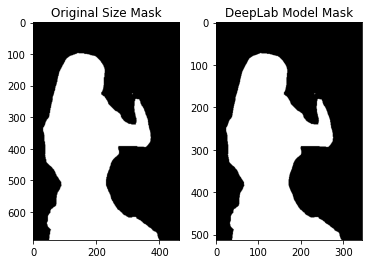

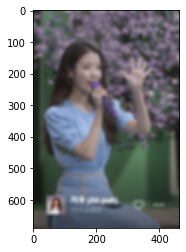

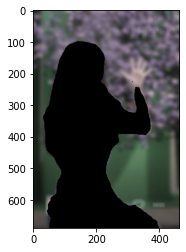

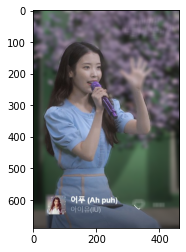

In [12]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/iu_image_2.png'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

img_orig_blur = cv2.blur(img_orig, (13,13)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Case 3

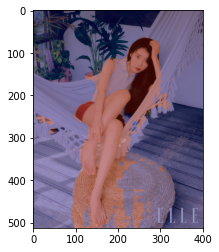

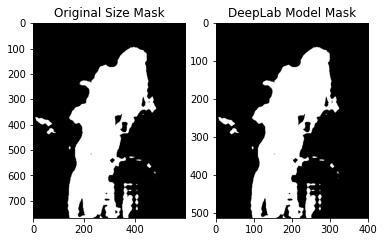

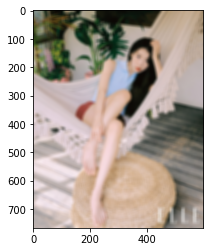

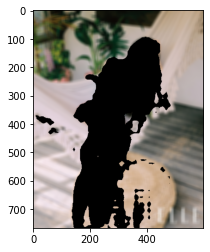

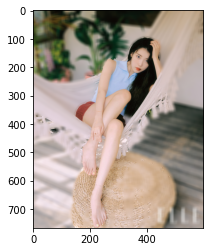

In [13]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/iu_image_3.png'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

img_orig_blur = cv2.blur(img_orig, (13,13)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Case 4

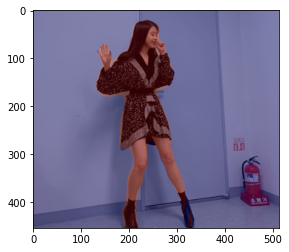

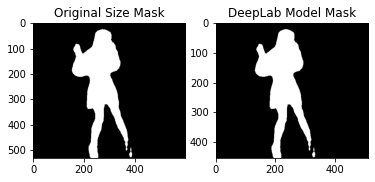

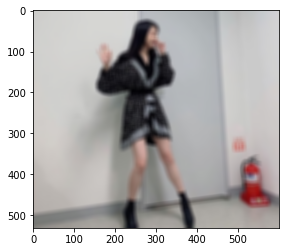

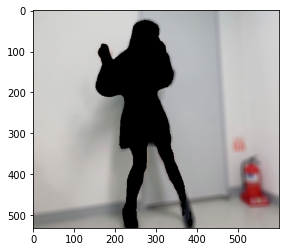

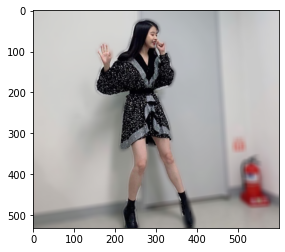

In [14]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/iu_image_4.png'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

img_orig_blur = cv2.blur(img_orig, (13,13)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Case 5

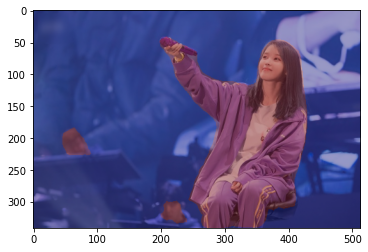

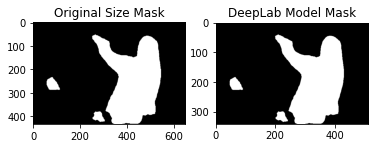

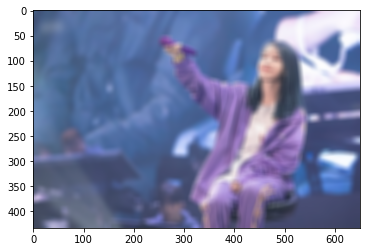

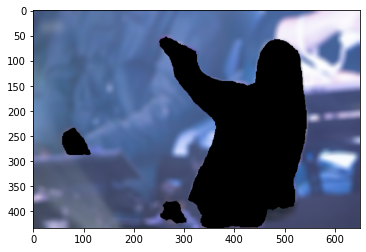

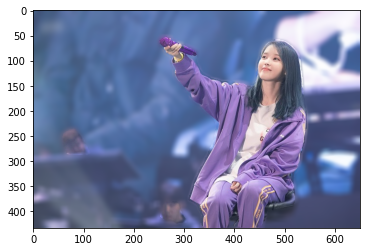

In [15]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/iu_image_5.png'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

img_orig_blur = cv2.blur(img_orig, (13,13)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2.2 고양이 사진

### Case 6

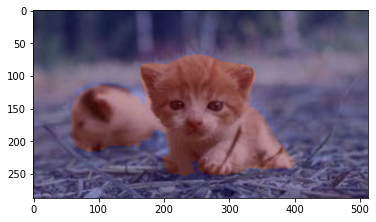

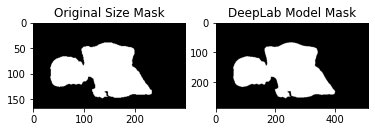

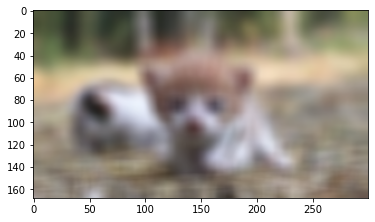

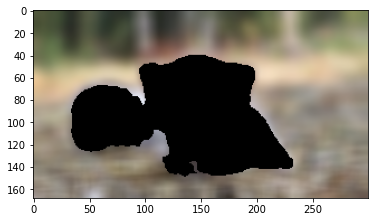

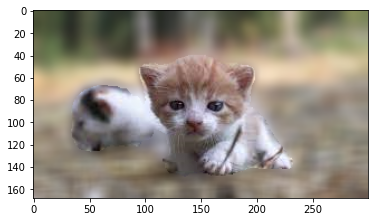

In [16]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/cat_image_1.png'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

img_orig_blur = cv2.blur(img_orig, (13,13)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Case 7

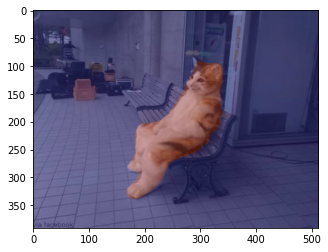

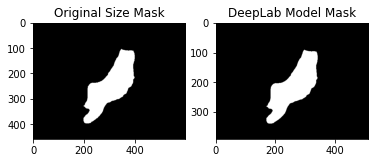

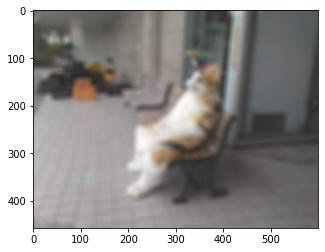

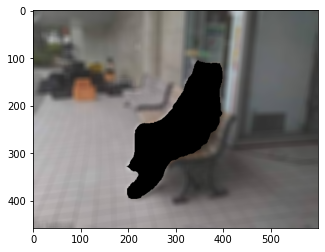

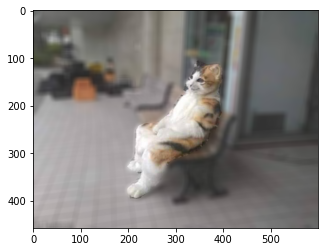

In [17]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/cat_image_2.png'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

img_orig_blur = cv2.blur(img_orig, (13,13)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Case 8

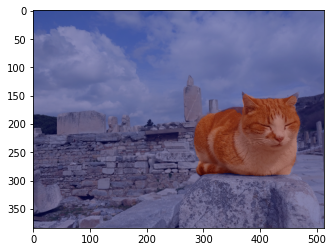

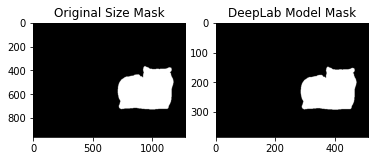

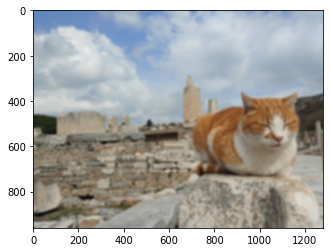

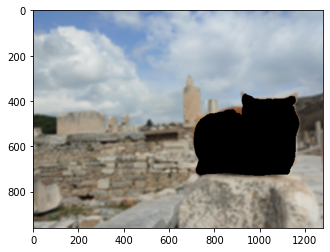

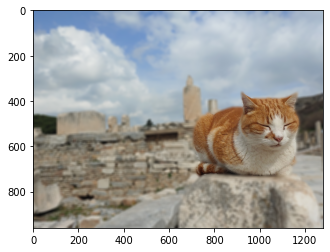

In [18]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/cat_image_3.png'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

img_orig_blur = cv2.blur(img_orig, (13,13)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 2.3 배경 전환 크로마키 사진

In [19]:
img_dir_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/'
save_dir_path = os.getenv('HOME') + '/aiffel/human_segmentation/save/'

In [20]:
def ChromaKey(file, label, background):
    img_path = os.path.join(img_dir_path, file)
    img_orig = cv2.imread(img_path)
    
    img_resized, seg_map = MODEL.run(img_orig)

    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0)
    img_mask = seg_map * (255/seg_map.max())
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    bg_path = os.path.join(img_dir_path, background)
    bg_orig = cv2.imread(bg_path)
    target_size = (img_orig.shape[1], img_orig.shape[0])
    bg_resized = cv2.resize(bg_orig, target_size)
    
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_concat = np.where(img_mask_color==255, img_orig, bg_resized)
    save_path = os.path.join(save_dir_path, file)
    cv2.imwrite(save_path, img_concat)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

* 배경 전환 크로마키 사진을 만들기 위해서, ChromaKey 함수를 구현
* file: 이미지에서 원하는 피사체를 배경과 분리한 후, 기존 크기로 복원
* label: 원하는 피사체의 label이 무엇인지 입력
* background: 피사체를 합성 할 배경 사진으로, 앞서 만든 피사체 사진과 배경 사진을 합성

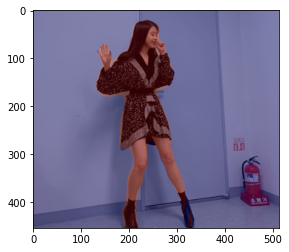

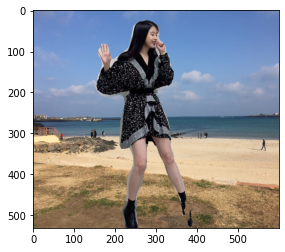

In [21]:
ChromaKey('iu_image_4.png', 'person', 'background_1.png')

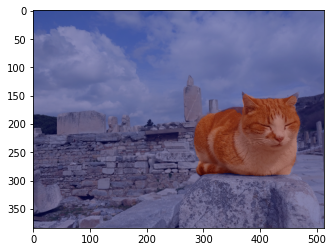

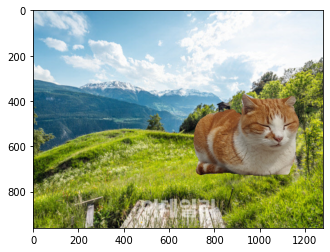

In [22]:
ChromaKey('cat_image_3.png', 'cat', 'background_2.png')

## 3. 문제점 해결

### 3.1 Gaussian Smoothing
#### case 4. 배경과 피사체의 경계가 애매한 케이스

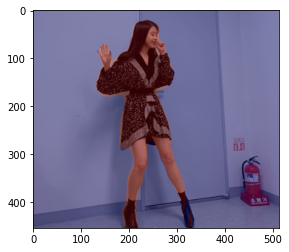

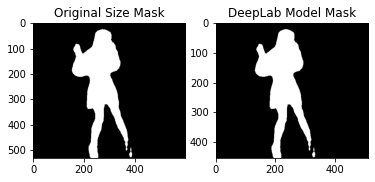

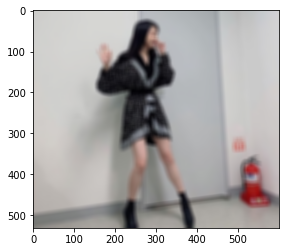

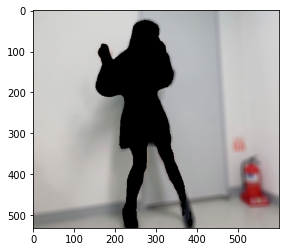

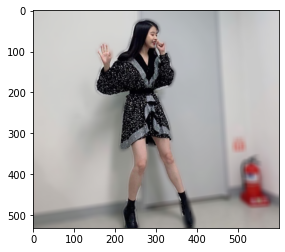

In [34]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/iu_image_4.png'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

img_orig_blur = cv2.blur(img_orig, (13,13)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 기존 블러 처리의 문제는, 배경과 피사체의 경계가 애매하게 처리되는 경우가 존재한다는 점
* 이러한 문제를 해결하기 위해서, **Gaussian Smoothing**을 사용
* 참고: https://webnautes.tistory.com/1255

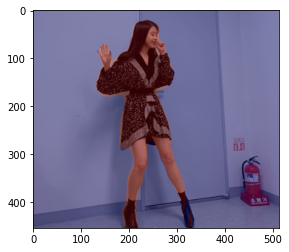

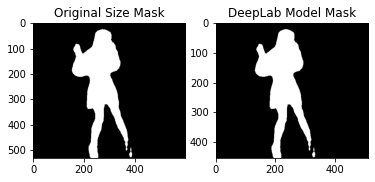

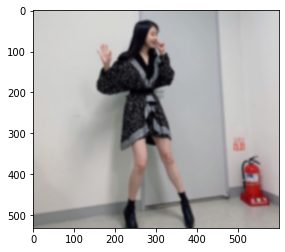

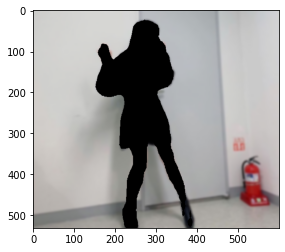

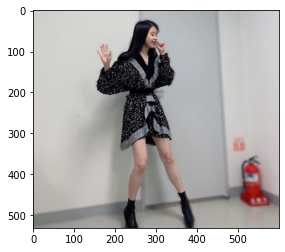

In [37]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/iu_image_4.png'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

# img_orig_blur = cv2.blur(img_orig, (13,13))
img_orig_blur = cv2.GaussianBlur(img_orig, (13, 13), 0)

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 기존에 블러 처리를 위해 사용했던 cv2.blur() 대신에, cv2.GaussianBlur()를 이용
* GaussianBlur를 사용한 경우, 배경과 피사체의 경계가 자연스러워진 것을 확인
    + 기존에 blur를 사용한 경우, 배경과 피사체의 경계에 검은색 선이 존재했고, 선의 바깥쪽 영역을 블러 처리했기 때문에, 경계가 부자연스러운 측면이 있었음

### 3.2 Mask R-CNN (Instance Segmentation)
#### case 5. 여러 인물이 있는 이미지

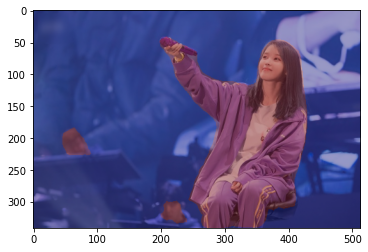

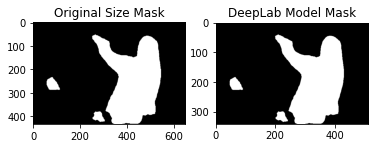

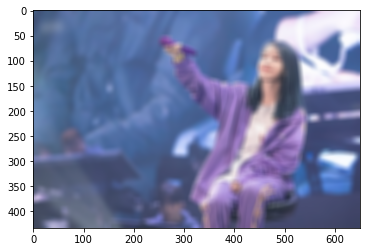

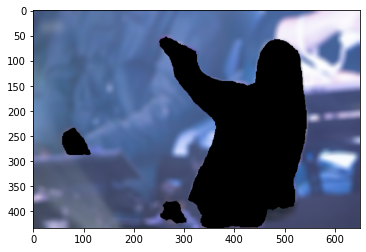

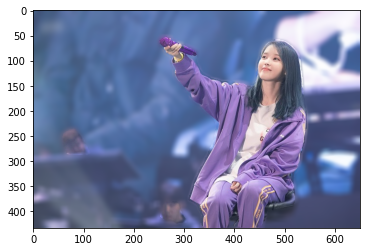

In [39]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/iu_image_5.png'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

img_orig_blur = cv2.blur(img_orig, (13,13)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 기존 semantic segmentation의 문제는, 이미지 내의 모든 클래스를 같은 label로 인식하고 처리하는 것
* 위의 이미지처럼 사람이 많을 때는, 모든 사람들을 제외하고 배경을 블러 처리
* 만약, 특정 대상만 남기고 나머지 부분을 모두 블러 처리하길 원한다면 다른 방법을 사용해야함 (instance segmentation)

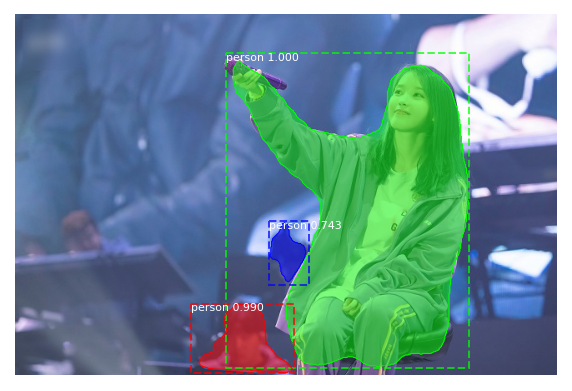

In [40]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize

mrcnn_dir = os.getenv('HOME') + '/aiffel/human_segmentation/mrcnn/mrcnn/'

CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

class cocoInferenceConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = len(CLASS_NAMES)
    
model_mrcnn = mrcnn.model.MaskRCNN(mode="inference",
                             config=cocoInferenceConfig(),
                             model_dir=os.path.join(mrcnn_dir, 'model.py'))

model_mrcnn.load_weights(filepath="mask_rcnn_coco.h5", by_name=True)

img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/iu_image_5.png'
img_orig = cv2.imread(img_path)
img_mrcnn = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

results = model_mrcnn.detect([img_mrcnn], verbose=0)
r = results[0]

mrcnn.visualize.display_instances(img_mrcnn, r['rois'], r['masks'], r['class_ids'], 
                                  CLASS_NAMES, r['scores'], figsize=(10, 10))

* 참고: https://wikidocs.net/79350
* instance segmentation에서 가장 많이 사용되는 Mask R-CNN model을 이용
* 해당 model은, 같은 label이어도 각각의 객체로 분리하여 인식
* 위 이미지처럼, 사람이 여러명 인식되는 이미지에서 사람을 각각의 별도의 객체로 인식
* Mask R-CNN을 이용하기 위해서는, Mask R-CNN 라이브러리가 필요

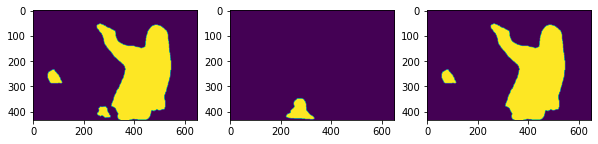

In [41]:
remove_idx = 1
remove_person = r['masks'][:,:,1]

img_mask = np.where(remove_person == 1, 0, img_mask_up)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1); plt.imshow(img_mask_up)
plt.subplot(1,3,2); plt.imshow(remove_person)
plt.subplot(1,3,3); plt.imshow(img_mask)
plt.show()

* Mask R-CNN을 이용하여, 사람들을 하나의 label이 아닌 별도의 객체로 판별
* 이후, 삭제할 사람 객체를 선택하여 삭제
---
* 이미지의 가장 왼쪽에 있는 사람도 삭제하고 싶지만, 객체로서 인식되지 않았기에 해당 label에 접근할 수 없었음
    + 객체로 인식되지 않았다고 생각되는 이유는, 위의 이미지를 보면, 가장 왼쪽에 있는 사람의 경우, mask가 생성되지 않았음을 확인할 수 있음. 왜 mask가 생성되지 않았는지 정확한 이유는 모르겠음

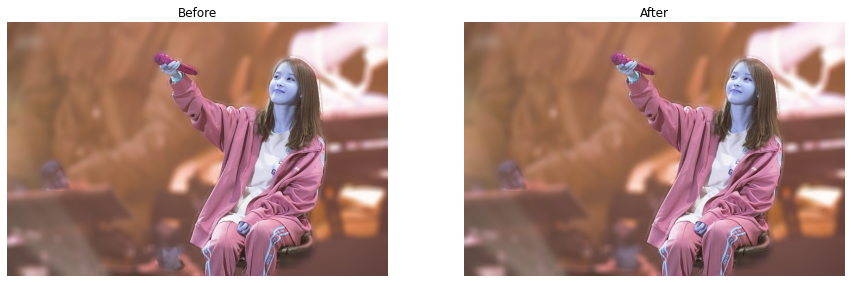

In [42]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2RGB)
result_img = np.where(img_mask_color == 255, img_orig, img_orig_blur)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img_concat); plt.axis('off')
plt.title('Before');

plt.subplot(1,2,2)
plt.imshow(result_img); plt.axis('off')
plt.title('After');
plt.show()

* 배경을 블러 처리한 후, 이미지를 살펴보면 원하는 인물을 제외하고 나머지 인물들은 블러 처리가 된 것을 확인할 수 있음
    + 앞서 언급한 것 처럼, 가장 왼쪽에 있는 사람은 블러처리가 되지 않았음. 왜 mask가 생성되지 않는 것일까? 블러 처리가 안 된것을 보면 사람으로 인식했다고 판단되는데, 왜 앞에서는 mask가 생성되지 않았는지 이해할 수 없다.

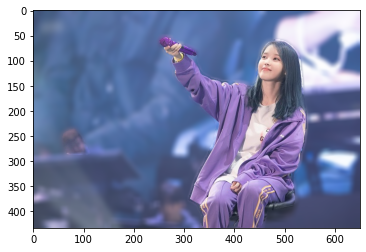

In [28]:
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.show()

* 이미지의 색을 RGB로 변환하여, 최종 이미지를 출력

## 4. 회고

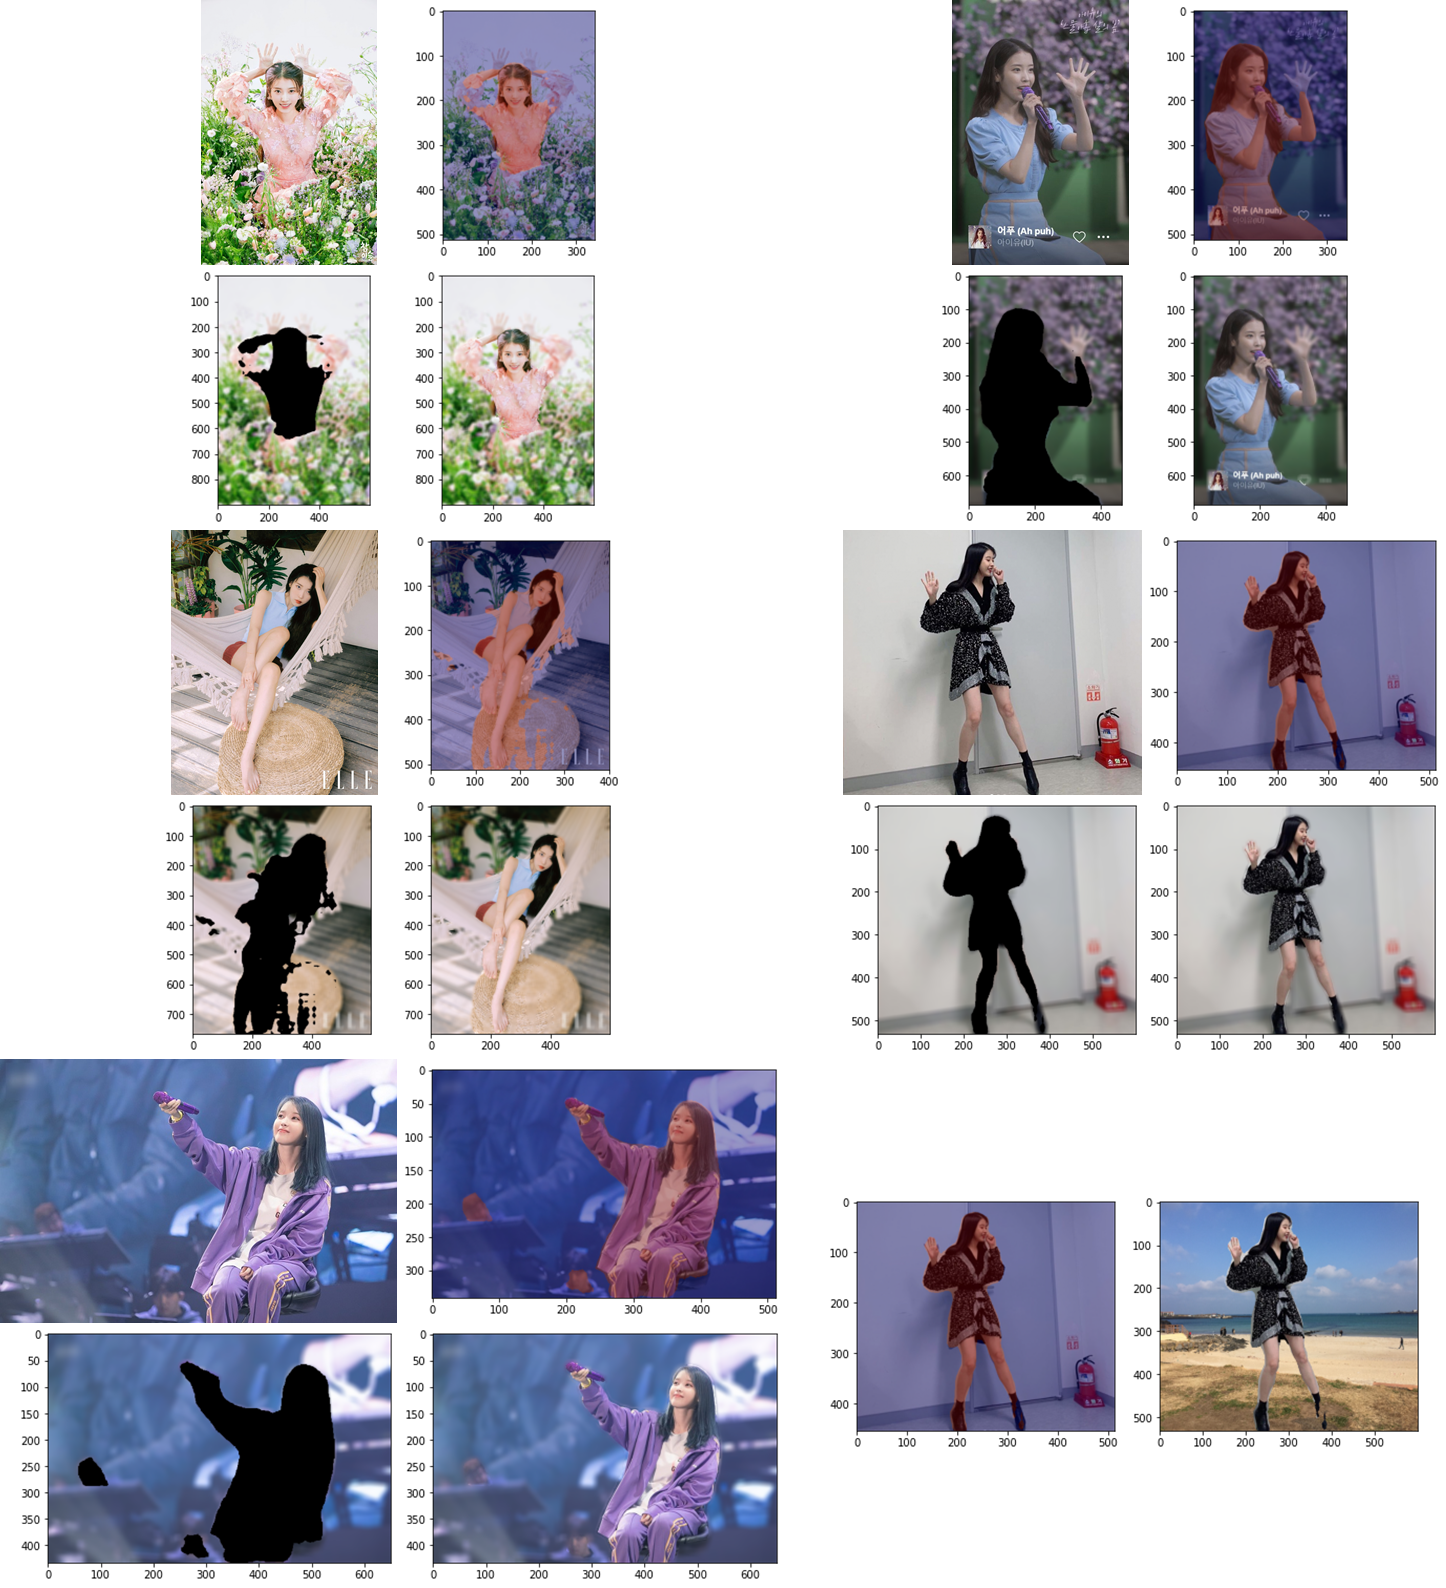

* 좌측 상단부터 오른쪽으로 1, 2 / 3, 4 / 5, 6 이미지로 칭하겠음
---
### * 문제점
   
   
1. 1, 2, 3, 4번 이미지들의 경우, 인물의 일부분**(팔, 손, 발)**을 제대로 인식하지 못하고 블러 처리를 하거나, 인물이 아닌 사물을 블러처리 하지 않았음
  
  
2. 5번 이미지의 경우, 원하는 대상뿐만 아니라, 원하지 않는 대상에 대해서 블러 처리가 이루어지지 않았음
  
  
3. 4, 6번 이미지의 경우, 배경과 인물 사이의 경계가 애매함

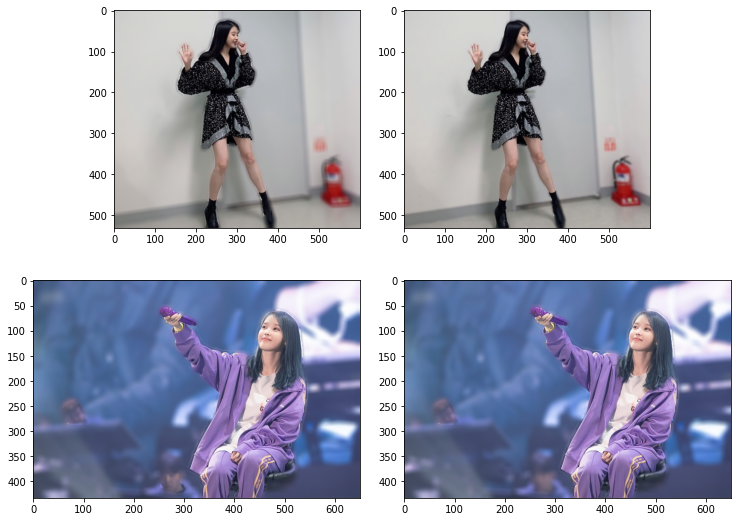

### * 해결법
  
1. 해당 문제는, 이미지 내에서 피사체와 배경의 경계가 불분명하기때문에 발생한 문제라고 판단. 그러한 이유는 각 이미지들에서 사람으로 인식되지 않은 부위가 주변 배경의 색, 밝기 등과 비슷하거나, 신발과 같이 사람의 신체라고 판단하기 어려운 부분에서 발생했음. (4번 이미지의 경우, 인물의 발이 너무 작아서 생긴 문제가 아닌가 판단)
    + 이러한 문제를 해결하기 위해서는, 코드의 수정보다는 판단에 무리가 없는 확실한 이미지를 선택하는 것이 더 좋다고 생각함. 이 문제를 해결할 수 있는 확실한 방법에 대해서는 찾을 수 없었음
  
  
2. 해당 문제는, 이미지 내의 동일한 label이 많았기에 발생한 문제라고 판단. 우리가 이번 노드에서 사용한 semantic segmentation은 label에 의해서 mask를 생성하고, 같은 label이라고 판단되는 mask들은 별 다른 구분 없이 동일한 mask로 인식함. 따라서, semantic segmentation을 이용하면 해당 문제를 해결할 수 없음.
    + 이러한 문제를 해결하기 위해서는, instance segmentation을 이용해야 함. instance segmentation은 같은 label로 생성된 mask여도, 별도의 객체로서 인식함. 그렇기에 원하지 않는 피사체에 대해서 배경과 함께 블러 처리가 가능함. instance segmentation에서 가장 많이 사용된다고 알려진 Mask R-CNN을 이용하여 문제를 해결함.
  
  
3. 해당 문제는, 피사체와 배경을 분리할 때 만들어지는 경계선의 문제라고 판단. 피사체보다 조금 큰 범위의 경계를 만들기 때문에, 배경과 피사체 사이의 경계가 부자연스러운 경향이 있음. 왜 피사체보다 조금 더 큰 범위의 경계를 만드는 지는 잘 모르겠으나, 안정적으로 배경과 피사체를 분리하기 위해서 그런 것이 아닐까 판단.
    + 이러한 문제를 해결하기 위해서, 기존에 사용한 cv2.blur()가 아닌 cv2.GaussianBlur()를 사용. GaussianBlur는 가우시안 분포를 이용한 블러 처리로, 픽셀의 위치에 따라서 가중치를 다르게 설정하여 계산하는 방식. 

### * 느낀점
* 해당 노드를 처음 봤을 때, Exploration 03 노드(Camera Sticker)와 굉장히 유사하다고 생각했고, 쉽게 해결하겠구나 싶었다. 그러나, 진짜 어려웠던 것 같다. 피사체와 배경을 분리하여 블러 처리하는 것은 크게 어렵지 않았다. 그러나, 노드를 진행하면서 발생하는 문제들에 대해서 어떻게 해결해야 하는가 고민을 정말 많이 했다. Mask R-CNN을 적용하는 것이 가장 어려웠다. 예제 코드를 찾는 것도 어려웠고, 가장 왼쪽에 있는 사람의 mask가 생성되지 않는 문제를 해결하는 것도 어려웠다. (물론, mask 문제는 해결하지 못했다. 아직도 이유를 모르겠다.) 지금까지 CV 노드를 진행하면서, 가장 어려운 노드가 아니었나 생각한다.